In [1]:
from sys import byteorder
from array import array
from struct import pack
import numpy as np
import matplotlib
import math
import scipy

import pyaudio
import wave


In [2]:
import sample
import matplotlib.pyplot as plt

In [3]:
def plotter(path):
    s = sample.Sample.from_file("data/{}".format(path))
    x,y = s.get_smooth_data()
    idx = 0
    while x[idx] < sample.BASE_CUTOFF:
        idx += 1
    x = x[idx:]
    y = y[idx:]
    plt.subplot(211)
    plt.plot(x,y,"-")
    x,y = s.get_data(32)
    plt.subplot(212)
    plt.plot(x,y,"-")
    plt.show()

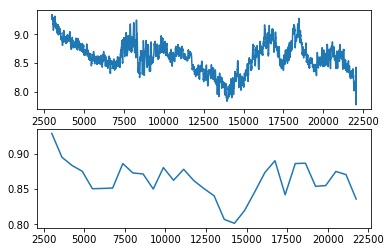

In [4]:
plotter("x-pad/0.wav")

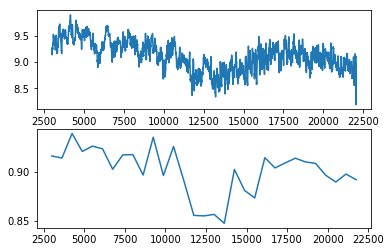

In [5]:
plotter("x-pad/4.wav")

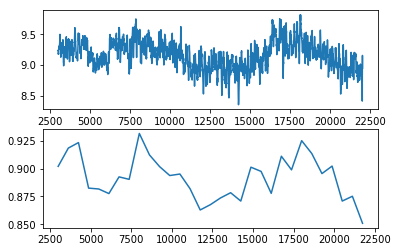

In [6]:
plotter("x-pad/6.wav")

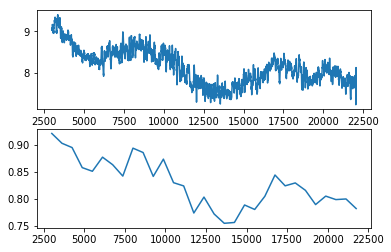

In [7]:
plotter("o-pad/3.wav")

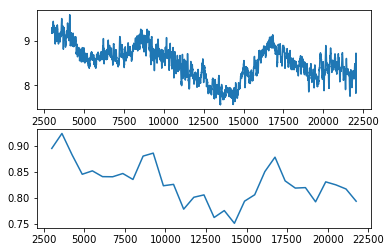

In [8]:
plotter("o-pad/8.wav")

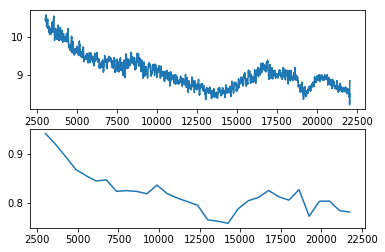

In [9]:
plotter("o-pad/14.wav")

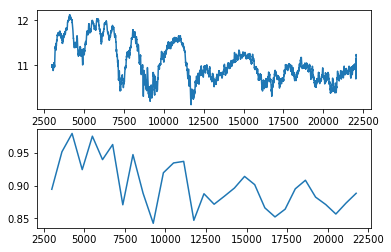

In [10]:
plotter("x-nail/7.wav")

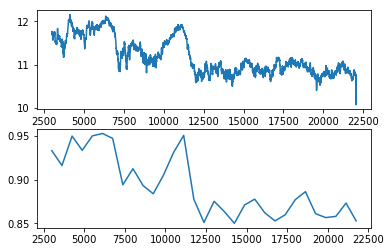

In [11]:
plotter("x-nail/10.wav")

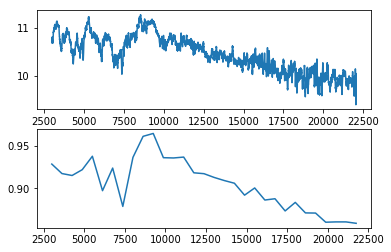

In [12]:
plotter("x-nail/14.wav")

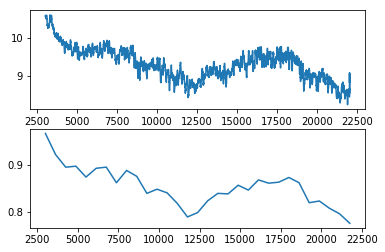

In [13]:
plotter("swipe_down-pad/2.wav")

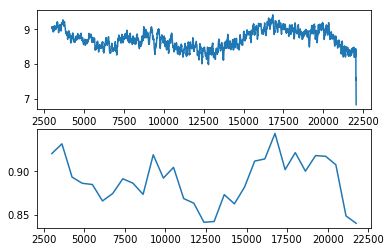

In [14]:
plotter("swipe_up-pad/8.wav")

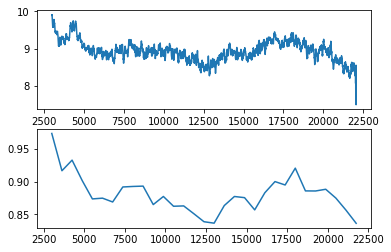

In [15]:
plotter("swipe_up-pad/4.wav")